In [1]:
import pandas as pd
from ForestDiffusion import ForestDiffusionModel
import pickle

GENERATIVE_COLUMNS = ["UPDRS I", "UPDRS II", "UPDRS III", "UPDRS IV", "PDQ", "MoCA"]
MAX_SCORES = {
    "Mobility": 40,
    "Daily living": 24,
    "Emotion": 24,
    "Stigmatization": 16,
    "Social support": 12,
    "Cognition": 16,
    "Communication": 12,
    "Bodily discomfort": 12,
}
TARGET_COLUMNS = list(MAX_SCORES.keys())

X_amp = pd.read_csv("../data/updrs_amp_all.csv", na_values="Unknown")

# Filter out multiple measurements
# X_amp = X_amp[X_amp["Visit ID"] == "M0"].reset_index()

X_amp.columns = X_amp.columns.str.replace("ADL", "Daily living", regex=False)
X_amp.columns = X_amp.columns.str.replace("Stigma", "Stigmatization", regex=False)
X_amp.columns = X_amp.columns.str.replace("Social", "Social support", regex=False)
X_amp.columns = X_amp.columns.str.replace(
    "Discomfort", "Bodily discomfort", regex=False
)

value_map = {
    "Never": 0,
    "Occasionally": 1,
    "Sometimes": 2,
    "Often": 3,
    "Always or cannot do at all": 4,
}

# Convert relevant columns using the map to numerical values
for col in X_amp.columns:
    if col.startswith("PDQ39"):
        X_amp[col] = X_amp[col].map(value_map).astype(pd.Int64Dtype())

for key, value in MAX_SCORES.items():
    selected_columns = X_amp.filter(like=key)
    assert len(selected_columns.columns) * 4 == value
    X_amp[key] = selected_columns.sum(axis=1, skipna=False)
    X_amp[key] = (X_amp[key] * 100) / value
    X_amp = X_amp.drop(columns=selected_columns.columns)

# Cast the UPDRS scoresx
for col in X_amp.columns:
    if col.startswith("UPDRS"):
        X_amp[col] = X_amp[col].astype(pd.Int64Dtype())

UPDRS_I_columns = X_amp.filter(like="UPDRS 1.")
UPDRS_II_columns = X_amp.filter(like="UPDRS 2.")
UPDRS_III_columns = X_amp.filter(like="UPDRS 3.")
UPDRS_IV_columns = X_amp.filter(like="UPDRS 4.")

X_amp["PDQ"] = X_amp[TARGET_COLUMNS].mean(axis=1)
X_amp["MoCA"] = X_amp["MoCA"] / 30 * 100
# X_amp = X_amp.dropna(subset=["PDQ"])

X_amp["UPDRS I"] = pd.to_numeric(
    X_amp["UPDRS I"] / (len(UPDRS_I_columns.columns) * 4) * 100
).astype(float)
X_amp["UPDRS II"] = pd.to_numeric(
    X_amp["UPDRS II"] / (len(UPDRS_II_columns.columns) * 4) * 100
).astype(float)
X_amp["UPDRS III"] = pd.to_numeric(
    X_amp["UPDRS III"] / (len(UPDRS_III_columns.columns) * 4) * 100
).astype(float)
X_amp["UPDRS IV"] = pd.to_numeric(
    X_amp["UPDRS IV"] / (len(UPDRS_IV_columns.columns) * 4) * 100
).astype(float)

X_amp = X_amp.dropna(subset=GENERATIVE_COLUMNS, thresh=1)

scores = pd.DataFrame(
    {
        "Time since diagnosis": ((X_amp["Age"] - X_amp["Age (Diagnosis)"]) / 20) * 2
        - 1,
        "Age": X_amp["Age"] / 100 * 2 - 1,
        "Sex": X_amp["Sex"].map({"Female": -1.0, "Male": 1.0}),
        "Medication": X_amp["Medication"].map({True: 1.0, False: -1.0}),
        "Surgery": X_amp["Surgery"].map({True: 1.0, False: -1.0}),
        "Education": X_amp["Education"].map(
            {
                "Less than 12 years": -1.0,
                "12-16 years": 0.0,
                "Greater than 16 years": 1.0,
            }
        ),
    }
).to_numpy()

X_amp[GENERATIVE_COLUMNS]

,UPDRS I,UPDRS II,UPDRS III,UPDRS IV,PDQ,MoCA
0,17.307692,21.153846,11.363636,37.500000,<NA>,96.666667
1,15.384615,21.153846,9.090909,16.666667,<NA>,100.000000
2,19.230769,21.153846,25.000000,25.000000,<NA>,93.333333
3,17.307692,26.923077,22.727273,0.000000,<NA>,83.333333
4,7.692308,5.769231,13.636364,25.000000,<NA>,96.666667
...,...,...,...,...,...,...
13163,3.846154,3.846154,12.878788,NaN,<NA>,NaN
13164,0.000000,1.923077,12.878788,NaN,<NA>,NaN
13165,5.769231,1.923077,11.363636,NaN,<NA>,NaN
13166,1.923077,3.846154,6.818182,NaN,<NA>,90.000000


In [2]:
def load_uke_data(path: str):
    SCORES = ["UPDRS I", "UPDRS II", "UPDRS III", "UPDRS IV", "PDQ", "MoCA"]
    COVARIATES = ["Age (Diagnosis)", "Age", "Sex", "Education", "Medication"]

    data = pd.read_csv(
        path,
        sep=",",
        na_values=[
            "Keine_Angabe",
            "Nicht_durchgeführt",
            "Keine_Angaben",
            "Keine_angabe",
        ],
    )

    def education_mapper(age):
        if pd.isna(age):
            return pd.NA
        elif age < 12:
            return -1.0
        elif age > 16:
            return 1.0
        else:
            return 0.0

    def normalize_scores(scores):
        scores["UPDRS I"] = scores["UPDRS I"] / (len(UPDRS_I_columns.columns) * 4) * 100
        scores["UPDRS II"] = (
            scores["UPDRS II"] / (len(UPDRS_II_columns.columns) * 4) * 100
        )
        scores["UPDRS III"] = (
            scores["UPDRS III"] / (len(UPDRS_III_columns.columns) * 4) * 100
        )
        scores["UPDRS IV"] = (
            scores["UPDRS IV"] / (len(UPDRS_IV_columns.columns) * 4) * 100
        )
        scores["MoCA"] *= 100
        return scores

    scores = []
    targets = []
    for _, group in data.groupby("Patient"):
        group = group.sort_values("Month").reset_index(drop=True)

        baseline = group[group["Month"] == 0][SCORES + COVARIATES + ["Month"]].dropna(
            thresh=len(SCORES) - 3
        )
        treated = group[group["Month"] > 0][SCORES + ["Month"]].dropna()
        if len(baseline) == 0 or len(treated) == 0:
            continue

        baseline = baseline.iloc[0]
        baseline["Time since last test"] = (
            treated.iloc[0]["Month"] - baseline["Month"]
        ) / 12
        baseline["Treatment"] = 1.0
        scores.append(
            baseline[SCORES + COVARIATES + ["Time since last test", "Treatment"]]
        )

        targets.append(treated.iloc[0][SCORES])

    uke_scores = pd.DataFrame(scores).reset_index(drop=True)
    uke_covariates = uke_scores[COVARIATES].copy()
    uke_covariates["Education"] = pd.to_numeric(
        uke_covariates["Education"].map(education_mapper), errors="coerce"
    )
    uke_covariates["Sex"] = uke_covariates["Sex"].map({1.0: -1.0, 0.0: 1.0})
    uke_covariates["Time since diagnosis"] = (
        (uke_covariates["Age"] * 100 - uke_covariates["Age (Diagnosis)"]) / 20
    ) * 2 - 1
    uke_covariates["Medication"] = uke_covariates["Medication"].map(
        {"ON": 1.0, "OFF": -1.0}
    )
    uke_covariates["Surgery"] = -1.0
    uke_covariates["Age"] = uke_covariates["Age"] * 2 - 1

    uke_scores = uke_scores.drop(
        columns=COVARIATES + ["Time since last test", "Treatment"]
    )
    uke_scores = normalize_scores(uke_scores)

    uke_targets = pd.DataFrame(targets).reset_index(drop=True)
    uke_targets = normalize_scores(uke_targets)

    return (
        uke_scores,
        uke_covariates[
            ["Time since diagnosis", "Age", "Sex", "Medication", "Surgery", "Education"]
        ],
        uke_targets,
    )


x_uke, covariates_uke, y_uke = load_uke_data(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/pdq_uke_new.csv"
)
x_uke


valid_measurements = (~pd.isna(x_uke["PDQ"])) & (~pd.isna(y_uke["PDQ"]))
x_uke = x_uke[valid_measurements]
covariates_uke = covariates_uke[valid_measurements]
y_uke = y_uke[valid_measurements]

## Train the model

In [3]:
x = X_amp[GENERATIVE_COLUMNS].copy()
x = x / 100 * 2 - 1
x = x.to_numpy()

forest_model = ForestDiffusionModel(
    x,
    n_t=50,
    duplicate_K=100,
    X_covs=scores,
    diffusion_type="flow",
    n_jobs=-1,
)

with open("tree.pickle", "wb") as f:
    pickle.dump(forest_model, f)

In [3]:
with open("tree.pickle", "rb") as f:
    forest_model = pickle.load(f)

In [4]:
validation_set = (X_amp["Study"] == "BioFIND") & (X_amp["Visit ID"] == "M0")

x_real = X_amp[validation_set][GENERATIVE_COLUMNS]
x_generated = pd.DataFrame(
    ((forest_model.generate(len(scores[validation_set]), X_covs=scores[validation_set]) + 1) / 2) * 100,
    columns=GENERATIVE_COLUMNS,
)

## Benchmark data

In [ ]:
from sdmetrics.single_column import KSComplement
from sdmetrics.column_pairs import CorrelationSimilarity
import numpy as np

print(np.nanmean([KSComplement.compute(
    real_data=x_real[column],
    synthetic_data=x_generated[column]
) for column in GENERATIVE_COLUMNS]))

print(CorrelationSimilarity.compute(
    real_data=x_real,
    synthetic_data=x_generated
))

## Generate some data

In [4]:
import numpy as np


def generate_samples(model, x, x_covariates, n_samples: int = 50) -> pd.DataFrame:
    generated_samples = []
    for ((i, sample), (_, row)) in zip(x.iterrows(), x_covariates.iterrows()):
        covariates = np.repeat(row.to_numpy()[np.newaxis, :], n_samples, axis=0)
        prediction = pd.DataFrame(
            ((model.generate(len(covariates), X_covs=covariates) + 1) / 2) * 100,
            columns=x.columns,
        )

        for key, value in sample.items():
            if pd.isna(value):
                continue

            generated_samples.append(
                pd.DataFrame.from_dict(
                    {
                        "Prediction": prediction[key],
                        "Ground truth": value,
                        "Score": key,
                        "Subject": i,
                        "Sample ID": np.arange(n_samples),
                    }
                )
            )

    return pd.concat(generated_samples, ignore_index=True)


uke_samples = generate_samples(forest_model, x_uke, covariates_uke, n_samples=500)

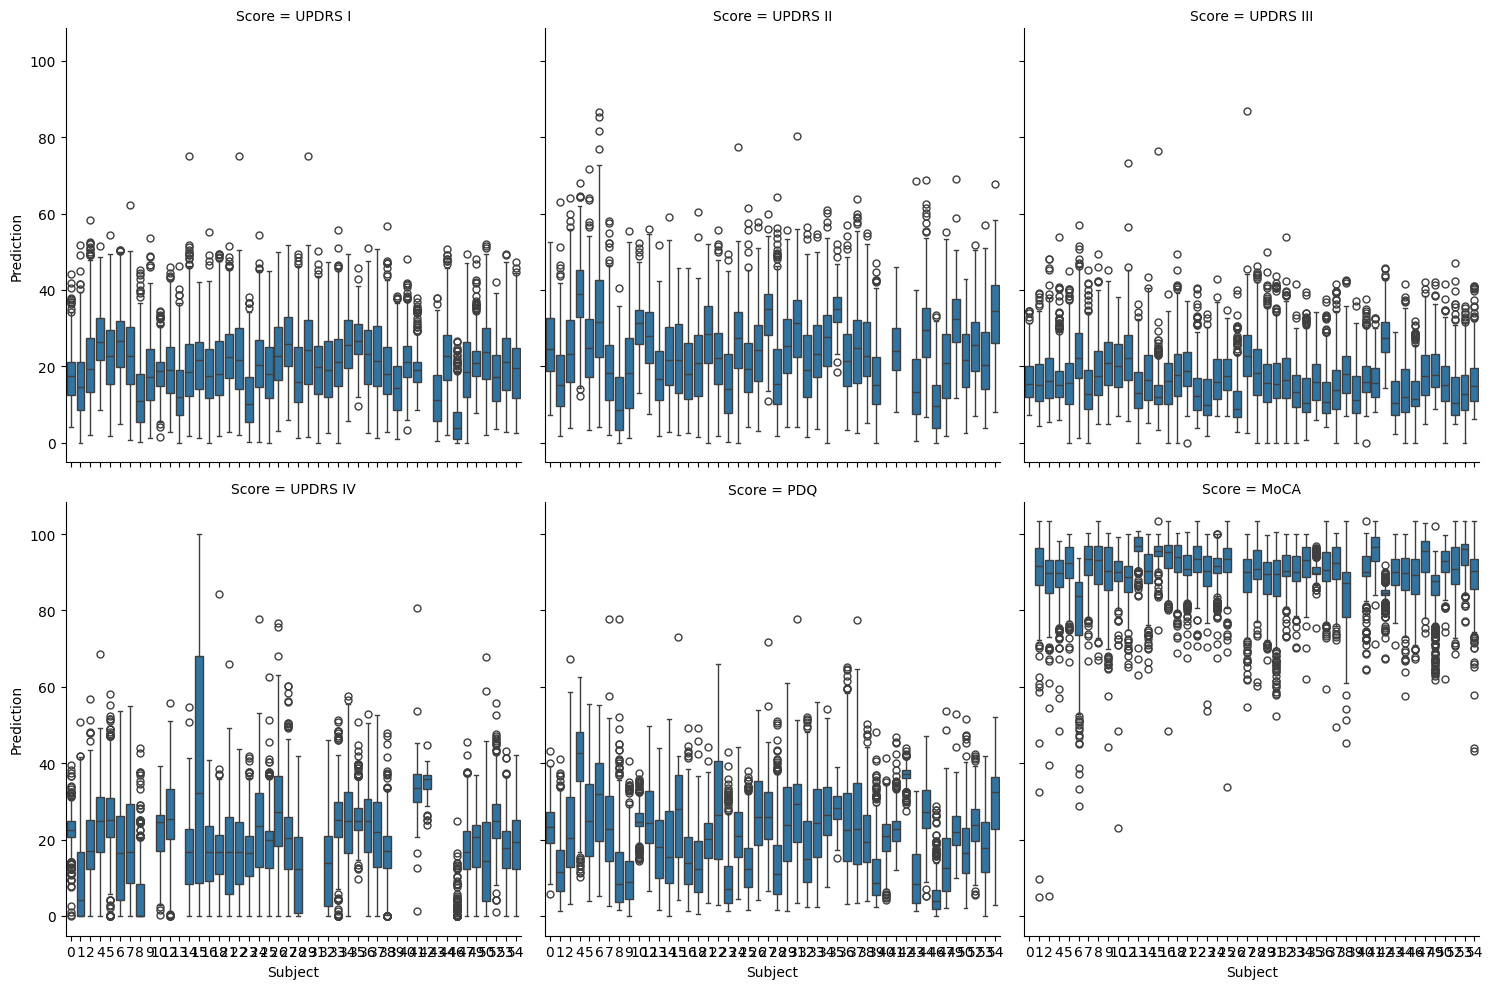

In [5]:
import seaborn as sns

sns.catplot(
    data=uke_samples, x="Subject", y="Prediction", col="Score", col_wrap=3, kind="box"
)

17.815610500141347
17.483071352041428


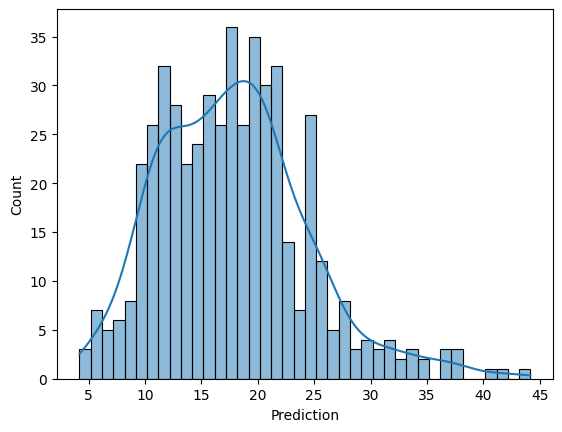

In [6]:
selection = uke_samples[(uke_samples["Score"] == "UPDRS I") & (uke_samples["Subject"] == 0)]

sns.histplot(selection, x="Prediction", binwidth=1, kde=True)
print(selection["Prediction"].mean())
print(selection["Prediction"].median())

In [7]:
z_scores = []
for subject, data in uke_samples.groupby("Subject"):
    for score, score_data in data.groupby("Score"):
        mean = score_data["Prediction"].median()
        std = score_data["Prediction"].std()
        #mean = score_data["Prediction"].median()
        #std = (score_data["Prediction"] - mean).abs().median() + 1e-6
        
        ground_truth = score_data["Ground truth"].iloc[0]
        ground_truth_score = (ground_truth - mean) / std
        z_scores.append((subject, score, ground_truth_score))

z_scores = (
    pd.DataFrame.from_records(z_scores, columns=["Subject", "Score", "Z-Score"])
    .pivot(index="Subject", columns="Score", values="Z-Score")
    .reset_index()
    .set_index("Subject")
)
z_scores["Label"] = (x_uke["PDQ"] - y_uke["PDQ"]) > 4.72

z_scores

Score,MoCA,PDQ,UPDRS I,UPDRS II,UPDRS III,UPDRS IV,Label
Subject,,,,,,,
0,NaN,-1.747824,-1.486398,-0.388898,0.466839,3.845140,False
1,0.532010,-0.807504,-0.132831,0.418777,2.579030,-0.366655,False
2,-1.283392,0.686543,-0.186393,0.157225,0.465831,-0.025637,False
4,0.023492,-2.728857,-2.537182,-0.051581,1.208382,3.631714,False
5,0.163527,0.470391,-0.896894,0.370750,1.515047,1.629175,True
6,1.543255,1.546335,0.036871,1.565427,0.703308,2.326748,True
7,-0.630413,-0.739609,-0.892853,-1.368355,1.351419,2.272041,True
8,-0.998394,1.954042,0.474559,1.847524,-0.383209,5.443597,True
9,-0.036101,0.281949,0.011983,0.570679,1.683547,NaN,False


0.6730769230769231


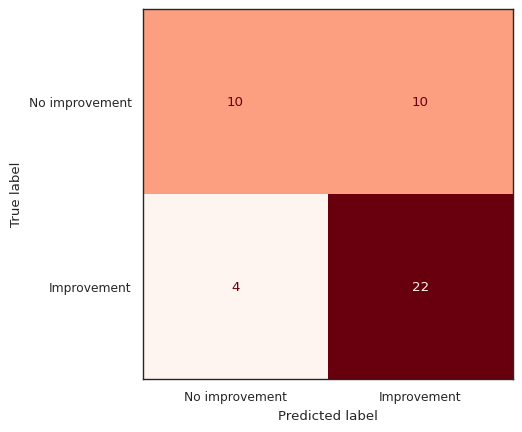

In [8]:
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_predict, LeaveOneOut
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, roc_auc_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# cv = StratifiedKFold(10, random_state=42, shuffle=True)
cv = LeaveOneOut()
# x = pd.concat([z_scores.drop(columns=["Label"])], axis=1)
x = z_scores.drop(columns=["Label"]).round(2)
# x = z_scores.drop(columns=["Label"]).round(2).fillna(0)
y_pred = cross_val_predict(
    HistGradientBoostingClassifier(min_samples_leaf=5, max_depth=3),
    # LogisticRegression(max_iter=1000),
    # KNeighborsClassifier(n_neighbors=3),
    x,
    z_scores["Label"],
    cv=cv,
)

with sns.axes_style("white"):
    sns.set_context("paper")
    ConfusionMatrixDisplay.from_predictions(z_scores["Label"], y_pred, cmap="Reds", colorbar=False, display_labels=["No improvement", "Improvement"])

print(roc_auc_score(z_scores["Label"], y_pred))

In [9]:
x = pd.concat([z_scores.drop(columns=["Label"])], axis=1)
y = (x_uke["PDQ"] - y_uke["PDQ"]) / (x_uke["PDQ"] + y_uke["PDQ"])
y_pred = cross_val_predict(
    HistGradientBoostingRegressor(min_samples_leaf=5, max_depth=3),
    x,
    y,
    cv=cv,
)

mean_squared_error(y, y_pred)

0.1137659175252001

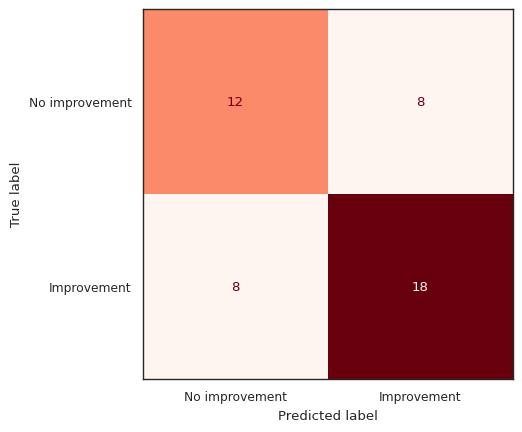

In [10]:
x = pd.concat([x_uke, covariates_uke], axis=1)
y = (x_uke["PDQ"] - y_uke["PDQ"]) > 4.72
y_pred = cross_val_predict(
    HistGradientBoostingClassifier(min_samples_leaf=5, max_depth=3),
    x,
    y,
    cv=cv,
)

with sns.axes_style("white"):
    sns.set_context("paper")
    ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap="Reds", colorbar=False, display_labels=["No improvement", "Improvement"])

## Check correlations

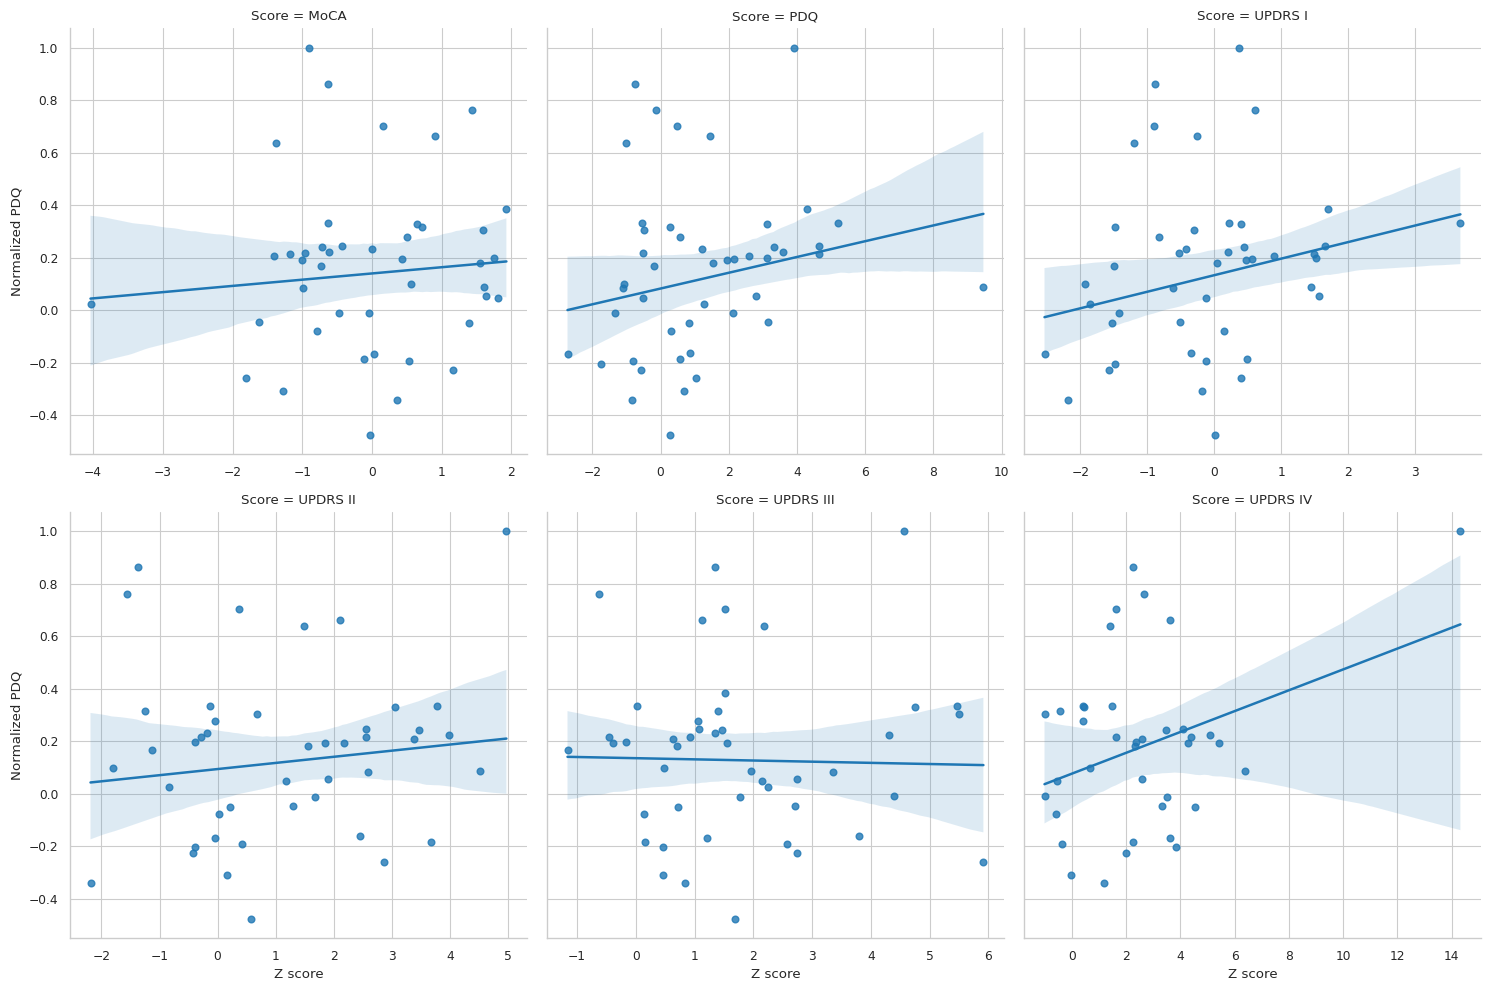

In [13]:
regscores = z_scores.copy()
regscores["Normalized PDQ"] = (x_uke["PDQ"] - y_uke["PDQ"]) / (x_uke["PDQ"] + y_uke["PDQ"])
regscores = regscores.reset_index().melt(id_vars=["Subject", "Label", "Normalized PDQ"], value_name="Z score")

with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    
    sns.lmplot(
        data=regscores, x="Z score", y="Normalized PDQ", col="Score", col_wrap=3, facet_kws=dict(sharex=False, sharey=True), robust=True
    )

## Conditional average treatment effect

In [39]:
covariates_uke_with_surgery = covariates_uke.copy()
covariates_uke_with_surgery["Surgery"] = 1.0

uke_samples_simulated_with_surgery = generate_samples(
    forest_model, y_uke, covariates_uke_with_surgery, n_samples=200
)

In [ ]:
simulation_joined = uke_samples_simulated_with_surgery.rename(
    columns={"Prediction": "Prediction (Post)", "Ground truth": "Ground truth (Post)"}
).set_index(["Subject", "Sample ID", "Score"]).join(
    uke_samples.set_index(["Subject", "Sample ID", "Score"])
).rename({"Prediction": "Prediction (Pre)", "Ground truth": "Ground truth (Pre)"}, axis=1)

simulation_joined["Estimated effect"] = simulation_joined["Prediction (Post)"] - simulation_joined["Prediction (Pre)"]
simulation_joined["True effect"] = simulation_joined["Ground truth (Post)"] - simulation_joined["Ground truth (Pre)"]

simulation_joined = simulation_joined.reset_index()
simulation_joined

In [ ]:
import matplotlib.pyplot as plt

def hdi(ary, hdi_prob=0.95, skipna=False):
    """Compute hpi over the flattened array."""
    if isinstance(ary, pd.Series):
        ary = ary.to_numpy()
    ary = ary.flatten()
    if skipna:
        nans = np.isnan(ary)
        if not nans.all():
            ary = ary[~nans]
    n = len(ary)
    ary = np.sort(ary)
    interval_idx_inc = int(np.floor(hdi_prob * n))
    n_intervals = n - interval_idx_inc
    interval_width = np.subtract(
        ary[interval_idx_inc:], ary[:n_intervals], dtype=np.float64
    )

    if len(interval_width) == 0:
        raise ValueError("Too few elements for interval calculation. ")

    min_idx = np.argmin(interval_width)
    hdi_min = ary[min_idx]
    hdi_max = ary[min_idx + interval_idx_inc]

    return hdi_min, hdi_max

def annotate(data, **kws):
    ax = plt.gca()
    sns.scatterplot(data=data.groupby("Subject")["True effect"].mean().reset_index(), x="Subject", y="True effect", ax=ax, color="r")
    #data.groupby("Subject")["True effect"].mean().plot(ax=ax, marker="*", color="r", markersize=5, alpha=0.75)
    
with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    grid = sns.catplot(
        data=simulation_joined,
        x="Subject",
        y="Estimated effect",
        #hue="Clinical meaningful improvement",
        errorbar=hdi,
        estimator=np.median,
        linestyles="none",
        alpha=0.75,
        #order=subject_order,
        col="Score",
        col_wrap=3,
        kind="point",
    )
    grid.map_dataframe(annotate)
    grid.set_xlabels("")
    grid.set_xticklabels([])
    grid.figure.show()

https://movementdisorders.onlinelibrary.wiley.com/doi/10.1002/mdc3.14229
https://movementdisorders.onlinelibrary.wiley.com/doi/10.1002/mdc3.14262


Estimated UPDRS after THS